## Code

In [1]:
simulate = False

In [2]:
import sys

sys.path.append('../..')

In [3]:
from finance.discountfactor import ConstantRateDiscountFactor 

r = 0.02
discount = ConstantRateDiscountFactor(r)

In [4]:
import numpy as np
from scipy.stats import norm
from maths.montecarlo.processes.brownianmotions import GeometricBrownianMotion

maturity = 5.
step = 1./360
time_grid = GeometricBrownianMotion.generate_time_grid(0, maturity, step)

x_0 = [100]
mu_s = [[0.12]]
sigma_s = [0.2]

gbm = GeometricBrownianMotion(time_grid, x_0, mu_s, sigma_s)

In [5]:
print gbm.drifts
print gbm.vols

[[ 0.12]]
[[ 0.2]]


In [6]:
from finance.products.european.swap import (
    SwapContract,
)

delta = 0.25
coupon_dates = SwapContract.generate_payment_dates(0, maturity, delta)

swap = SwapContract(gbm, discount, coupon_dates)
print swap
print "P_0 = %s" % swap.price(0.)
print "P_0^* = %s" % swap.price(0., incl_next_coupon=True)

Swap contract of maturity T = 5 years, over S^0 with strike K = 134.306, paying at {0.00, 0.25, 0.50, 0.75, 1.00, 1.25, 1.50, 1.75, 2.00, 2.25, 2.50, 2.75, 3.00, 3.25, 3.50, 3.75, 4.00, 4.25, 4.50, 4.75, 5.00}
P_0 = 8.5338189598
P_0^* = -1.13686837722e-13


### Test profile

In [7]:
p_fixed = 1.
strike = swap.strike

delta_times = swap.delta_time
discount_factors = [discount(t) for t in swap.pillars[1:]]

delta_beta_sum = np.dot(delta_times, discount_factors)

notional = p_fixed / (strike*delta_beta_sum)
print "Notional = %s" % notional

Notional = 0.0015687485053


In [8]:
if not simulate:
    import dill
    with open('IRS_price.pkl', 'rb') as f:
        prices = dill.load(f)['price']
        
    print "Loading prices from file. Number of paths: %i" % (prices.shape[0])
else:
    N = 5000
    prices = np.zeros((N, len(time_grid)))
    for i in range(N):
        gbm.simulate()
        for (j, t) in enumerate(time_grid):
            prices[i, j] = notional*swap.price(t, incl_next_coupon=True)

Loading prices from file. Number of paths: 15000


In [9]:
qu = np.percentile(prices, 97.5, axis=0)
qd = np.percentile(prices, 2.5, axis=0)
price_avg = np.mean(prices, 0)

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
#import seaborn as sns

In [11]:
from matplotlib.ticker import FuncFormatter

formatter_pct = FuncFormatter(lambda y, pos: "%.0f %%" % (100 * y))
formatter = FuncFormatter(lambda y, pos: "%.1f" % (y))

D:\Anaconda\lib\site-packages\matplotlib\__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


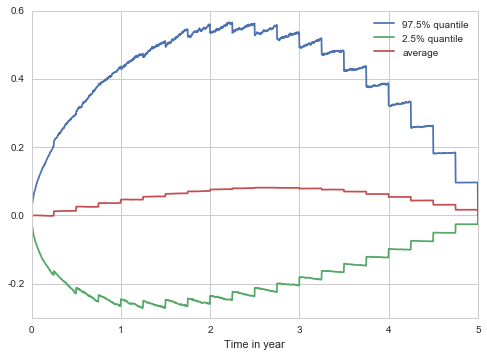

In [12]:
import seaborn as sns
sns.set_style("whitegrid")

plt.xlabel('Time in year')
plt.plot(time_grid, qu, label='97.5% quantile')
plt.plot(time_grid, qd, label='2.5% quantile')
plt.plot(time_grid, price_avg, label='average')

plt.gca().yaxis.set_major_formatter(formatter)

plt.legend(loc='best')
plt.show()

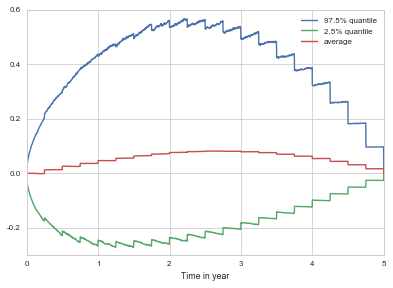

In [13]:
sns.set_context('paper')

plt.xlabel('Time in year')
plt.plot(time_grid, qu, label='97.5% quantile')
plt.plot(time_grid, qd, label='2.5% quantile')
plt.plot(time_grid, price_avg, label='average')

plt.gca().yaxis.set_major_formatter(formatter)

plt.legend(loc='best')
plt.show()

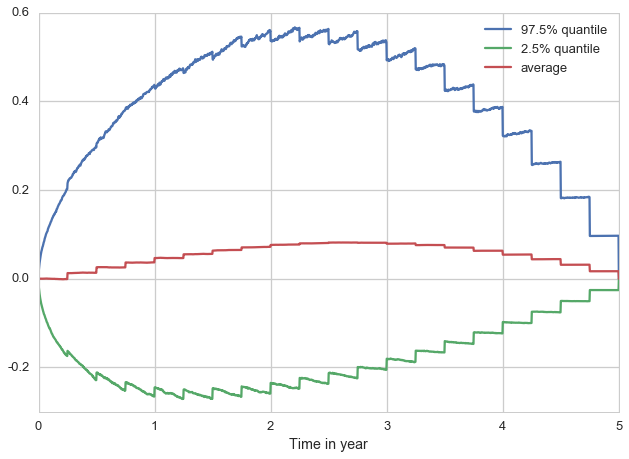

In [14]:
sns.set_context('talk')

plt.xlabel('Time in year')
plt.plot(time_grid, qu, label='97.5% quantile')
plt.plot(time_grid, qd, label='2.5% quantile')
plt.plot(time_grid, price_avg, label='average')

plt.gca().yaxis.set_major_formatter(formatter)

plt.legend(loc='best')
plt.show()

In [15]:
if simulate:
    import dill
    with open('IRS_price.pkl', 'rb') as f:
        old_prices = dill.load(f)['price']
    
    with open('IRS_price.pkl', 'wb') as f:
        dill.dump({"price": np.append(old_prices, prices, axis=0)}, f)